# Initialization

## Imports

In [1]:
import datetime
import json
import os

import plotly.graph_objects as go
import plotly.express as px
from tqdm import tqdm
import pandas as pd
import emoji

## Parameters

In [22]:
DATA_DIR = os.path.expanduser('~/code/telegram-explore/data/DataExport_2025-06-22')
PLOT_DIR = os.path.expanduser('~/code/telegram-data-analysis/plots')
RAW_DATA_PATH = os.path.join(DATA_DIR, 'result.json')
MESSAGES_DATAFRAME_PATH = os.path.join(DATA_DIR, 'messages.parquet')
CHATS_DATAFRAME_PATH = os.path.join(DATA_DIR, 'chats.parquet')
MY_ID = '103475519'
ANALYSIS_START_DATE = datetime.datetime(2019, 11, 1)

## Utils

In [3]:
def summarize_df(df, head_rows=5):
    print("Schema (columns and types):")
    print(df.dtypes)
    print("\nTotal rows:", len(df))
    print(f"\nFirst {head_rows} rows:")
    return df.head(head_rows)

# Messages Dataframe

In [4]:
def normalize_message(msg):
    text = msg.get('text', '')
    if isinstance(text, str):
        pass
    elif isinstance(text, list):
        clean_text = ''
        for sub_msg in text:
            if isinstance(sub_msg, str):
                clean_text += sub_msg
            elif isinstance(sub_msg, dict) and 'text' in sub_msg:
                clean_text += sub_msg['text']
        msg['text'] = clean_text
    else:
        raise NotImplementedError(f'text type: {type(text)}')
    
    return msg

In [17]:
if os.path.exists(MESSAGES_DATAFRAME_PATH) and os.path.exists(CHATS_DATAFRAME_PATH):
    message_df = pd.read_parquet(MESSAGES_DATAFRAME_PATH)
    chat_df = pd.read_parquet(CHATS_DATAFRAME_PATH)
else:
    with open(RAW_DATA_PATH, 'r') as f:
        data = json.load(f)

    records = []
    for chat in tqdm(data['chats']['list']):
        chat_id = chat['id']
        for msg in chat.get('messages', []):
            if msg['type'] == 'service':
                # consists of ['score_in_game', 
                # 'phone_call', 
                # 'pin_message', 
                # 'edit_chat_theme',
                # 'set_chat_wallpaper', 
                # 'set_same_chat_wallpaper', 
                # 'suggest_profile_photo', 
                # 'joined_telegram', 
                # 'clear_history']
                continue
            msg = normalize_message(msg)
            records.append({
                    **msg,
                    'chat_id': chat_id
                }
            )

    message_df = pd.DataFrame(records)
    message_df['date'] = pd.to_datetime(message_df['date'])
    message_df.to_parquet(MESSAGES_DATAFRAME_PATH)

    chat_df = pd.DataFrame(data['chats']['list']).drop('messages', axis=1)
    chat_df.to_parquet(CHATS_DATAFRAME_PATH)

message_df['from_me'] = message_df['from_id'] == f'user{MY_ID}'
message_df['month'] = message_df['date'].dt.to_period('M').astype(str)

summarize_df(message_df)

Schema (columns and types):
id                                       int64
type                                    object
date                            datetime64[ns]
date_unixtime                           object
from                                    object
from_id                                 object
file                                    object
file_name                               object
file_size                              float64
media_type                              object
mime_type                               object
duration_seconds                       float64
width                                  float64
height                                 float64
text                                    object
text_entities                           object
chat_id                                  int64
reply_to_message_id                    float64
thumbnail                               object
thumbnail_file_size                    float64
sticker_emoji                   

,id,type,date,date_unixtime,from,from_id,file,file_name,file_size,media_type,...,saved_from,giveaway_information,contact_information,contact_vcard,contact_vcard_file_size,self_destruct_period_seconds,place_name,address,from_me,month
0,373638,message,2020-10-03 11:25:24,1601711724,🦊,user103475519,(File not included. Change data exporting sett...,mp4.mp4,75436.0,animation,...,None,None,None,None,NaN,NaN,None,None,True,2020-10
1,373639,message,2020-10-03 11:25:50,1601711750,🦊,user103475519,None,None,NaN,None,...,None,None,None,None,NaN,NaN,None,None,True,2020-10
2,373640,message,2020-10-03 11:26:18,1601711778,🦊,user103475519,None,None,NaN,None,...,None,None,None,None,NaN,NaN,None,None,True,2020-10
3,373641,message,2020-10-03 11:33:00,1601712180,Maryam,user1310150538,None,None,NaN,None,...,None,None,None,None,NaN,NaN,None,None,False,2020-10
4,373642,message,2020-10-03 11:33:28,1601712208,Maryam,user1310150538,None,None,NaN,None,...,None,None,None,None,NaN,NaN,None,None,False,2020-10


In [6]:
summarize_df(chat_df)

Schema (columns and types):
name    object
type    object
id       int64
dtype: object

Total rows: 826

First 5 rows:


,name,type,id
0,Maryam,personal_chat,1310150538
1,None,saved_messages,103475519
2,M. Sadra,personal_chat,363386088
3,Mohammad,personal_chat,149897194
4,Arshia,personal_chat,759902365


# Preprocessing

In [7]:
preprocessed_message_df = message_df[message_df['date'] >= ANALYSIS_START_DATE]

summarize_df(preprocessed_message_df)

Schema (columns and types):
id                                       int64
type                                    object
date                            datetime64[ns]
date_unixtime                           object
from                                    object
from_id                                 object
file                                    object
file_name                               object
file_size                              float64
media_type                              object
mime_type                               object
duration_seconds                       float64
width                                  float64
height                                 float64
text                                    object
text_entities                           object
chat_id                                  int64
reply_to_message_id                    float64
thumbnail                               object
thumbnail_file_size                    float64
sticker_emoji                   

,id,type,date,date_unixtime,from,from_id,file,file_name,file_size,media_type,...,saved_from,giveaway_information,contact_information,contact_vcard,contact_vcard_file_size,self_destruct_period_seconds,place_name,address,from_me,month
0,373638,message,2020-10-03 11:25:24,1601711724,🦊,user103475519,(File not included. Change data exporting sett...,mp4.mp4,75436.0,animation,...,None,None,None,None,NaN,NaN,None,None,True,2020-10
1,373639,message,2020-10-03 11:25:50,1601711750,🦊,user103475519,None,None,NaN,None,...,None,None,None,None,NaN,NaN,None,None,True,2020-10
2,373640,message,2020-10-03 11:26:18,1601711778,🦊,user103475519,None,None,NaN,None,...,None,None,None,None,NaN,NaN,None,None,True,2020-10
3,373641,message,2020-10-03 11:33:00,1601712180,Maryam,user1310150538,None,None,NaN,None,...,None,None,None,None,NaN,NaN,None,None,False,2020-10
4,373642,message,2020-10-03 11:33:28,1601712208,Maryam,user1310150538,None,None,NaN,None,...,None,None,None,None,NaN,NaN,None,None,False,2020-10


# \# of messages

In [8]:
monthly_counts = message_df.groupby('month').size().reset_index(name='message_count')

fig = px.bar(
    monthly_counts,
    x='month',
    y='message_count',
    title='Monthly Message Count',
    labels={'month': 'Month', 'message_count': 'Messages'},
    template='plotly_white'
)

ANALYSIS_START_DATE_str = ANALYSIS_START_DATE.strftime('%Y-%m')
fig.update_layout(xaxis_tickangle=45)
fig.update_layout(width=1300)

fig.add_shape(
    type="line",
    x0=ANALYSIS_START_DATE_str,
    x1=ANALYSIS_START_DATE_str,
    y0=0,
    y1=1,
    yref="paper", 
    line=dict(color='red', width=2, dash='dash')
)

fig.add_annotation(
    x=ANALYSIS_START_DATE_str,
    y=max(monthly_counts['message_count']) * 0.9,  # Position near top
    text='Analysis Start Date',
    showarrow=True,
    arrowhead=2,
    arrowcolor='red',
    bgcolor='white',
    bordercolor='red'
)

fig.show()
fig.write_image(os.path.join(PLOT_DIR, "message_count.png"), width=1200)
# fig.write_html("plot.html")

In [9]:
sender_monthly = preprocessed_message_df.groupby(['month', 'from_me']).size().unstack(fill_value=0)
sender_monthly.columns = ['Others', 'Me']
sender_share = sender_monthly.div(sender_monthly.sum(axis=1), axis=0)

fig = go.Figure()
for sender in sender_share.columns:
    fig.add_trace(go.Scatter(
        x=sender_share.index,
        y=sender_share[sender],
        mode='lines',
        name=sender,
        stackgroup='one',
        line=dict(shape='spline'),
        hovertemplate='%{fullData.name}: %{y:.2%}<extra></extra>'
    ))

fig.update_layout(
    title='Monthly Share of Messages: Me vs Others',
    xaxis_title='Month',
    yaxis_title='Message Share',
    yaxis=dict(tickformat='.0%'),
    hovermode='x unified',
    template='plotly_white',
    width=1000,
    height=500
)

fig.update_xaxes(tickangle=45)
fig.show()
fig.write_image(os.path.join(PLOT_DIR, "message_share.png"), width=1000)

## Conversation Starter

In [10]:
def calculate_time_diff_by_id(df, time_col, id_col):
    df = df.sort_values(by=[id_col, time_col])
    df['prev_time'] = df.groupby(id_col)[time_col].shift(1)
    df['time_diff'] = df[time_col] - df['prev_time']
    df = df.drop('prev_time', axis=1)
    df['conversationStarter'] = ~(df['time_diff'] < datetime.timedelta(hours=24))
    df = df[df['conversationStarter']].drop(['conversationStarter', 'time_diff'], axis=1)
    return df

preprocessed_message_with_diff_df = calculate_time_diff_by_id(preprocessed_message_df.copy(), 'date', 'chat_id')

sender_monthly = preprocessed_message_with_diff_df.groupby(
    ['month', 'from_me']).size().unstack(fill_value=0)
sender_monthly.columns = ['Others', 'Me']

sender_share = sender_monthly.div(sender_monthly.sum(axis=1), axis=0)

fig = go.Figure()

for sender in sender_share.columns:
    fig.add_trace(go.Scatter(
        x=sender_share.index,
        y=sender_share[sender],
        mode='lines',
        name=sender,
        stackgroup='one',
        line=dict(shape='spline'),
        hovertemplate='%{fullData.name}: %{y:.2%}<extra></extra>'
    ))

fig.update_layout(
    title='Monthly Share of Conversation Starts: Me vs Others',
    xaxis_title='Month',
    yaxis_title='Start Share',
    yaxis=dict(tickformat='.0%'),
    hovermode='x unified',
    template='plotly_white',
    width=1000,
    height=500
)

fig.update_xaxes(tickangle=45)
fig.show()
fig.write_image(os.path.join(PLOT_DIR, "start_share.png"), width=1000)

# Emoji Analysis

## Preprocessing

In [11]:
my_message_df = preprocessed_message_df[preprocessed_message_df['from_me']]
my_message_df['emojis'] = my_message_df['text'].apply(emoji.distinct_emoji_list)
my_message_df = my_message_df[my_message_df['emojis'].apply(lambda x: bool(x))]
my_message_df = my_message_df[my_message_df['emojis'].apply(len) <= 6]
emoji_df = my_message_df[my_message_df['emojis'].apply(bool)].explode('emojis')[
    ['emojis', 'date']]
emoji_df = emoji_df.rename(columns={'emojis': 'emoji'}).reset_index(drop=True)

summarize_df(emoji_df)

/tmp/ipykernel_3405129/3970512237.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Schema (columns and types):
emoji            object
date     datetime64[ns]
dtype: object

Total rows: 272902

First 5 rows:


,emoji,date
0,😁,2020-10-03 11:38:33
1,🤔,2020-10-03 11:39:04
2,😁,2020-10-03 11:40:23
3,🤔,2020-10-03 11:40:40
4,🤔,2020-10-03 11:42:07


In [12]:
emoji_df['month'] = emoji_df['date'].dt.to_period('M')

top_emojis = emoji_df['emoji'].value_counts().head(10).index

popular_emoji_df = emoji_df[emoji_df['emoji'].isin(top_emojis)]

usage = popular_emoji_df.groupby(
    ['month', 'emoji']).size().unstack(fill_value=0)

usage.index = usage.index.astype(str)

fig = go.Figure()

emoji_totals = usage.sum().sort_values(ascending=False)
usage_share = usage.div(usage.sum(axis=1), axis=0)

fig = go.Figure()

for emoji_str in emoji_totals.index:
    fig.add_trace(go.Scatter(
        x=usage_share.index,
        y=usage_share[emoji_str],
        mode='lines',
        name=emoji_str,
        stackgroup='one',
        line=dict(width=0.5, shape='spline'),
        hovertemplate='%{fullData.name}: %{y:.2%}<extra></extra>'
    ))

fig.update_layout(
    title='Monthly Share of Popular Emojis',
    xaxis_title='Month',
    yaxis_title='Share',
    yaxis=dict(tickformat='.0%'),
    hovermode='x unified',
    template='plotly_white',
    width=1000,
    height=600,
)

fig.update_xaxes(tickangle=45)
fig.show()
fig.write_image(os.path.join(PLOT_DIR, "emoji_share.png"), width=1000)

## chats

In [23]:
joined_df = preprocessed_message_df[['chat_id', 'month']].merge(
    chat_df[['id', 'name']], left_on='chat_id', right_on='id', how='left')

joined_df['chat_label'] = joined_df.apply(
    lambda row: row['name'] if pd.notna(row['name']) else str(row['chat_id']),
    axis=1
)

top_contacts = joined_df['chat_id'].value_counts().head(10).index
popular_chats_df = joined_df[joined_df['chat_id'].isin(top_contacts)]

chat_usage = popular_chats_df.groupby(['month', 'chat_label']).size().unstack(fill_value=0)

chat_usage.index = chat_usage.index.astype(str)
chat_totals = chat_usage.sum().sort_values(ascending=False)
chat_share = chat_usage.div(chat_usage.sum(axis=1), axis=0)

import plotly.graph_objects as go

fig = go.Figure()
for label in chat_totals.index:
    fig.add_trace(go.Scatter(
        x=chat_share.index,
        y=chat_share[label],
        mode='lines',
        name=label,
        stackgroup='one',
        groupnorm='percent',
        line=dict(width=0.5, shape='spline'),
        hovertemplate='%{fullData.name}: %{y:.2%}<extra></extra>'
    ))

fig.update_layout(
    title='Monthly Share of Chats by Contact',
    xaxis_title='Month',
    yaxis_title='Share of Messages',
    yaxis=dict(tickformat='.0%'),
    hovermode='x unified',
    template='plotly_white',
    width=1000,
    height=600,
)

fig.update_xaxes(tickangle=45)
fig.show()
fig.write_image(os.path.join(PLOT_DIR, "chat_share.png"), width=1000)

## Word Cloud

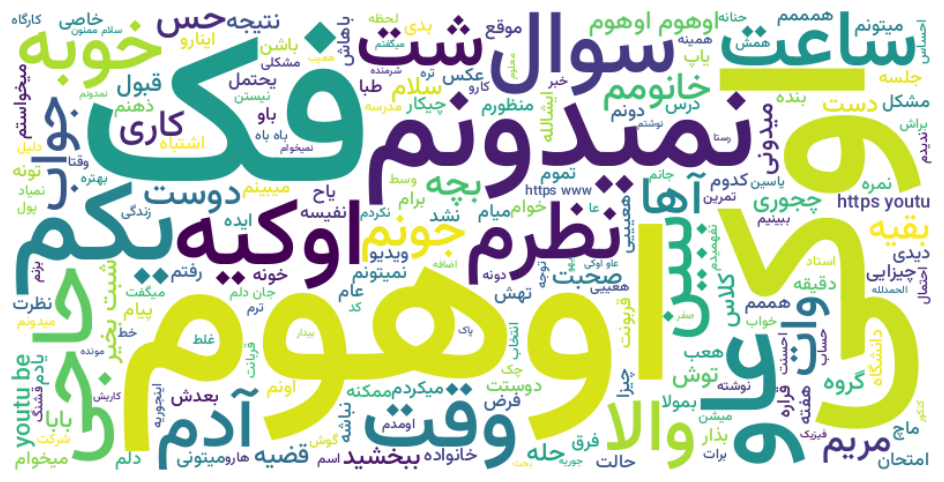

In [26]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

stopwords = set(open('stopwords.txt', 'r').read().strip().split('\n'))
my_messages = message_df[message_df['from_id'] == f'user{MY_ID}']


text = ' '.join(my_messages['text'].dropna().astype(str))

wordcloud = WordCloud(font_path='Vazirmatn-Medium.ttf', width=800, height=400, background_color='white', stopwords=stopwords).generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
wordcloud.to_file(os.path.join(PLOT_DIR, "wordcloud.png"))
# save as png

## Voices

In [15]:
my_voice_df = preprocessed_message_df[
    (preprocessed_message_df['media_type'] == 'voice_message') &
    (preprocessed_message_df['from_id'] == f'user{MY_ID}')
]

max_duration = my_voice_df['duration_seconds'].max()

longest_voice = my_voice_df[my_voice_df['duration_seconds'] == max_duration]

longest_voice = longest_voice.merge(chat_df, how='left', left_on='chat_id', right_on='id')

for _, row in longest_voice.iterrows():
    print('My longest voice')
    print(f"Duration: {int(row['duration_seconds'] // 60)}:{int(row['duration_seconds'] % 60)}")
    print(f"Date: {row['date']}")
    print(f"Chat name: {row['name']}")

print(f'median of all my voices: {int(my_voice_df['duration_seconds'].median())}')

My longest voice
Duration: 15:58
Date: 2020-09-19 15:30:13
Chat name: Yousefian
median of all my voices: 54
